# **CNN - Face Age Dataset**

## [Step 01] 라이브러리 로딩

In [7]:
import torchvision
import torchvision.transforms as transforms
import torchvision.models as models

import torch
import torch.nn as nn
import torch.optim as optim

from torch.utils.data import Dataset
from torch.utils.data import DataLoader

import matplotlib.pyplot as plt
import matplotlib.image as image
import numpy as np
import pandas as pd
from PIL import Image
import os

In [2]:
!nvidia-smi

Fri Feb 10 15:00:20 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA A100-SXM...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   34C    P0    51W / 400W |      0MiB / 40960MiB |      0%      Default |
|                               |                      |             Disabled |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## [Step 02] 데이터세트 다운로드

- Reference: https://aihub.or.kr/aihubdata/data/view.do?currMenu=115&topMenu=100&aihubDataSe=realm&dataSetSn=528

In [3]:
!wget -O dataset.zip https://www.dropbox.com/s/kbiyn2hfmjcma2q/dataset_faceage.zip?dl=1

--2023-02-10 15:00:25--  https://www.dropbox.com/s/kbiyn2hfmjcma2q/dataset_faceage.zip?dl=1
Resolving www.dropbox.com (www.dropbox.com)... 162.125.3.18, 2620:100:6018:18::a27d:312
Connecting to www.dropbox.com (www.dropbox.com)|162.125.3.18|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: /s/dl/kbiyn2hfmjcma2q/dataset_faceage.zip [following]
--2023-02-10 15:00:25--  https://www.dropbox.com/s/dl/kbiyn2hfmjcma2q/dataset_faceage.zip
Reusing existing connection to www.dropbox.com:443.
HTTP request sent, awaiting response... 302 Found
Location: https://uc874419f327b99423b71dbfc95a.dl.dropboxusercontent.com/cd/0/get/B2MpMHh8dbuE3IJD7FVadw2jEFhwZxcPRKZXRt21MonSsWGz1QURQM8Fn5qGcZ7YwMJi1qVlnKuePCRSkEJr-_UH3SmXkaA_1sK0n5MvlDteAvbo2ckgVboidAK0JX5kq1ckGtTOi8vuhRffD2XhWAPbVc-dyitlKfdG581ctUbNiQ/file?dl=1# [following]
--2023-02-10 15:00:25--  https://uc874419f327b99423b71dbfc95a.dl.dropboxusercontent.com/cd/0/get/B2MpMHh8dbuE3IJD7FVadw2jEFhwZxcPRKZXRt21MonSsWGz1QURQM8Fn

In [4]:
!unzip dataset.zip -d dataset_faceage
!rm -rf dataset.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: dataset_faceage/train_images/F0182_AGE_F_55_d1.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_F_55_d2.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_F_55_d3.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_F_55_e1.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_F_55_e2.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_F_55_e3.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_F_55_f1.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_F_55_f2.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_F_55_f3.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_S_20_a1.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_S_20_a2.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_S_20_a3.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_S_20_a4.jpg  
  inflating: dataset_faceage/train_images/F0182_AGE_S_20_b1.jpg  
  inflating: dataset_faceage/train_image

> 데이터 세트 불러오기
- Training dataset(F0001 ~ F0299): 10,025 이미지
- Validation dataset(F0801 ~ F0850): 1,539 이미지
- Test 데이터셋(F0851 ~ F0900): 1,504 이미지

In [5]:
"""
> [Function] Parse the metadata.
* image_age_list[0] = ["F0001_AGE_D_18_a1.jpg"] = "a"
* image_age_list[1] = ["F0001_AGE_D_18_a2.jpg"] = "a"
* image_age_list[2] = ["F0001_AGE_D_18_a3.jpg"] = "a"
* image_age_list[3] = ["F0001_AGE_D_18_a4.jpg"] = "a"
* image_age_list[4] = ["F0001_AGE_D_18_b1.jpg"] = "b"
...
"""

def parsing(meta_data):
    image_age_list = []
    
    # Iterate all rows in the metadata file
    for idx, row in meta_data.iterrows():
        image_path = row['image_path']
        age_class = row['age_class']
        image_age_list.append([image_path, age_class])
    return image_age_list

In [8]:
class Dataset(Dataset):
    def __init__(self, meta_data, image_directory, transform=None):
        self.meta_data = meta_data
        self.image_directory = image_directory
        self.transform = transform

        # Process the meta data
        image_age_list = parsing(meta_data)

        self.image_age_list = image_age_list
        self.age_class_to_label = {
            "a": 0, "b": 1, "c": 2, "d": 3, "e": 4, "f": 5, "g": 6, "h": 7
        }

    def __len__(self):
        return len(self.meta_data)
               
    def __getitem__(self, idx):
        image_path, age_class = self.image_age_list[idx]
        img = Image.open(os.path.join(self.image_directory, image_path))
        label = self.age_class_to_label[age_class]

        if self.transform:
            img = self.transform(img)
        
        return img, label

In [9]:
label_to_age = {
    0: "0-6 years old",
    1: "7-12 years old",
    2: "13-19 years old",
    3: "20-30 years old",
    4: "31-45 years old",
    5: "46-55 years old",
    6: "56-66 years old",
    7: "67-80 years old"
}

train_meta_data_path = "./dataset_faceage/custom_train_dataset.csv"
train_meta_data = pd.read_csv(train_meta_data_path)
train_image_directory = "./dataset_faceage/train_images"

val_meta_data_path = "./dataset_faceage/custom_val_dataset.csv"
val_meta_data = pd.read_csv(val_meta_data_path)
val_image_directory = "./dataset_faceage/val_images"

test_meta_data_path = "./dataset_faceage/custom_test_dataset.csv"
test_meta_data = pd.read_csv(test_meta_data_path)
test_image_directory = "./dataset_faceage/test_images"

train_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

val_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

test_transform = transforms.Compose([
    transforms.Resize(128),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5]) 
])

train_dataset = Dataset(train_meta_data, train_image_directory, train_transform)
train_dataloader = DataLoader(train_dataset, batch_size=256, shuffle=True)

val_dataset = Dataset(val_meta_data, val_image_directory, val_transform)
val_dataloader = DataLoader(val_dataset, batch_size=256, shuffle=False)

test_dataset = Dataset(test_meta_data, test_image_directory, test_transform)
test_dataloader = DataLoader(test_dataset, batch_size=256, shuffle=False)

## [Step 03] 데이터 시각화

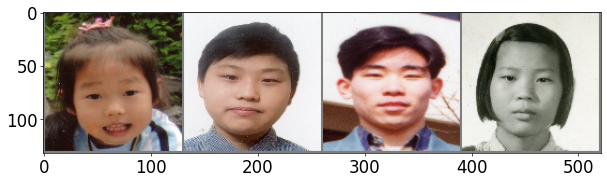

['7-12 years old', '13-19 years old', '20-30 years old', '13-19 years old']


In [10]:
plt.rcParams['figure.figsize'] = [12, 8]
plt.rcParams['figure.dpi'] = 60
plt.rcParams.update({'font.size': 20})

def imshow(input):

    # torch.Tensor => numpy
    input = input.numpy().transpose((1, 2, 0))
    
    # Undo image normalization
    mean = np.array([0.5, 0.5, 0.5])
    std = np.array([0.5, 0.5, 0.5])
    input = std * input + mean
    input = np.clip(input, 0, 1)
    
    # Display images
    plt.imshow(input)
    plt.show()

# Load a batch of train image
iterator = iter(train_dataloader)

# Visualize a batch of train image
imgs, labels = next(iterator)
out = torchvision.utils.make_grid(imgs[:4])
imshow(out)
print([label_to_age[labels[i].item()] for i in range(4)])

## [Step 04] 딥러닝 모델 학습

- 사전 학습된 모델을 활용하여 사용자 데이터 세트 학습
- 네트워크의 마지막에 FC 레이어를 적용하여 클래스 개수를 일치

In [11]:
learning_rate = 0.01
log_step = 20

model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)   # Transfer learning
model = model.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(model.parameters(), lr=learning_rate, momentum=0.9)

/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/resnet50-0676ba61.pth" to /root/.cache/torch/hub/checkpoints/resnet50-0676ba61.pth


  0%|          | 0.00/97.8M [00:00<?, ?B/s]

In [12]:
import time

def train():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Training]')
    model.train()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(train_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        outputs = model(imgs)
        optimizer.zero_grad()
        _, preds = torch.max(outputs, 1)
        loss = criterion(outputs, labels)
        
        loss.backward()
        optimizer.step()
        
        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)
        
        if i % log_step == log_step - 1:
            print(f'[Batch: {i + 1}] running train loss: {running_loss / total}, running train accuracy: {running_corrects / total}')

    print(f'train loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def validate():
    start_time = time.time()
    print(f'[Epoch: {epoch + 1} - Validation]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(val_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running val loss: {running_loss / total}, running val accuracy: {running_corrects / total}')

    print(f'val loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()


def test():
    start_time = time.time()
    print(f'[Test]')
    model.eval()
    total = 0
    running_loss = 0.0
    running_corrects = 0

    for i, batch in enumerate(test_dataloader):
        imgs, labels = batch
        imgs, labels = imgs.cuda(), labels.cuda()

        with torch.no_grad():
            outputs = model(imgs)
            _, preds = torch.max(outputs, 1)
            loss = criterion(outputs, labels)

        total += labels.shape[0]
        running_loss += loss.item()
        running_corrects += torch.sum(preds == labels.data)

        if (i == 0) or (i % log_step == log_step - 1):
            print(f'[Batch: {i + 1}] running test loss: {running_loss / total}, running test accuracy: {running_corrects / total}')

    print(f'test loss: {running_loss / total}, accuracy: {running_corrects / total}')
    print("elapsed time:", time.time() - start_time)
    return running_loss / total, (running_corrects / total).item()

In [13]:
import time

def adjust_learning_rate(optimizer, epoch):
    lr = learning_rate
    if epoch >= 3:
        lr /= 10
    if epoch >= 7:
        lr /= 10
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

num_epochs = 10
best_val_acc = 0
best_epoch = 0

history = []
accuracy = []
for epoch in range(num_epochs):
    adjust_learning_rate(optimizer, epoch)
    train_loss, train_acc = train()
    val_loss, val_acc = validate()
    history.append((train_loss, val_loss))
    accuracy.append((train_acc, val_acc))

    if val_acc > best_val_acc:
        print("[Info] best validation accuracy!")
        best_val_acc = val_acc
        best_epoch = epoch
        torch.save(model.state_dict(), f'best_checkpoint_epoch_{epoch + 1}.pth')

torch.save(model.state_dict(), f'last_checkpoint_epoch_{num_epochs}.pth')

[Epoch: 1 - Training]
[Batch: 20] running train loss: 0.006343400711193681, running train accuracy: 0.37519532442092896
[Batch: 40] running train loss: 0.005415870519053015, running train accuracy: 0.4660348892211914
train loss: 0.005415870519053015, accuracy: 0.4660348892211914
elapsed time: 22.98600125312805
[Epoch: 1 - Validation]
[Batch: 1] running val loss: 0.005159176420420408, running val accuracy: 0.49609375
val loss: 0.0059235616501776564, accuracy: 0.528265118598938
elapsed time: 1.791466474533081
[Info] best validation accuracy!
[Epoch: 2 - Training]
[Batch: 20] running train loss: 0.0029823822667822244, running train accuracy: 0.6986328363418579
[Batch: 40] running train loss: 0.002841431297863511, running train accuracy: 0.7237905263900757
train loss: 0.002841431297863511, accuracy: 0.7237905263900757
elapsed time: 14.55472183227539
[Epoch: 2 - Validation]
[Batch: 1] running val loss: 0.0044854008592665195, running val accuracy: 0.51953125
val loss: 0.005428994995498905, a

## [Step 05] 학습 결과 확인

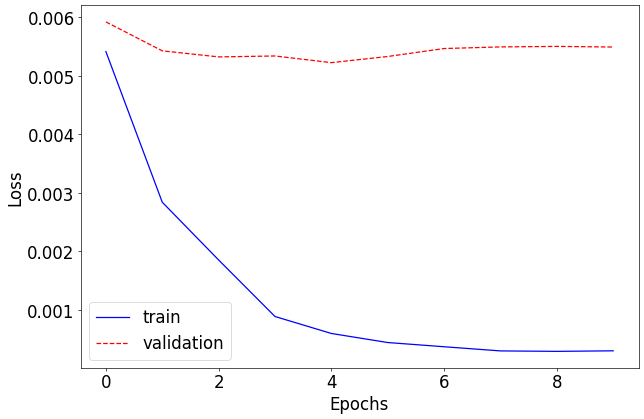

In [14]:
plt.plot([x[0] for x in history], 'b', label='train')
plt.plot([x[1] for x in history], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

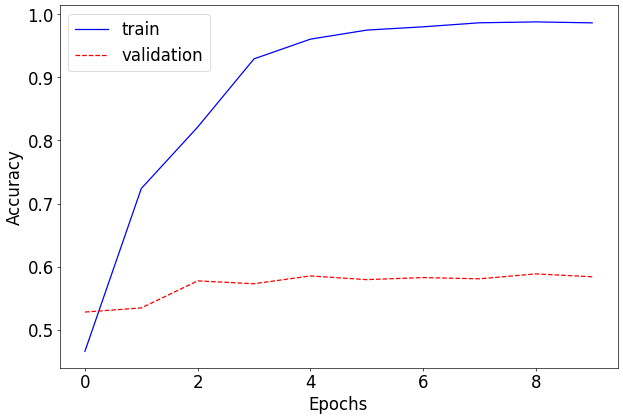

In [15]:
plt.plot([x[0] for x in accuracy], 'b', label='train')
plt.plot([x[1] for x in accuracy], 'r--',label='validation')
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

In [16]:
model = models.resnet50(pretrained=True)
num_features = model.fc.in_features
model.fc = nn.Linear(num_features, 8)   # of classes
model = model.cuda()
model_path = 'best_checkpoint_epoch_9.pth'
model.load_state_dict(torch.load(model_path))

test_loss, test_accuracy = test()
print(f"Test loss: {test_loss:.8f}")
print(f"Test accuracy: {test_accuracy * 100.:.2f}%")

[Test]
[Batch: 1] running test loss: 0.003456826088950038, running test accuracy: 0.703125
test loss: 0.004048132555598908, accuracy: 0.6482712626457214
elapsed time: 1.7445728778839111
Test loss: 0.00404813
Test accuracy: 64.83%


예측 결과: 13-19 years old


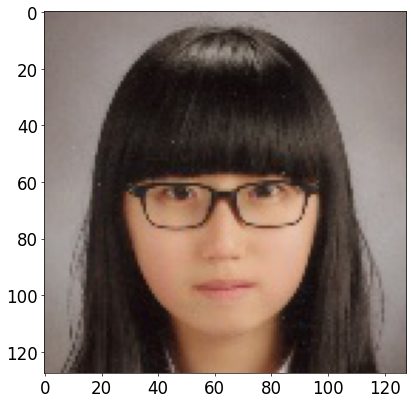

In [26]:
# Test
filename = f'F0861_AGE_D_21_c2.jpg'
image = Image.open('./dataset_faceage/test_images/' + filename).convert('RGB')
image = test_transform(image).unsqueeze(0).cuda()

with torch.no_grad():
    outputs = model(image)
    _, preds = torch.max(outputs, 1)
    print("예측 결과:", label_to_age[preds[0].item()])
    imshow(image.cpu().data[0])